In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station     = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

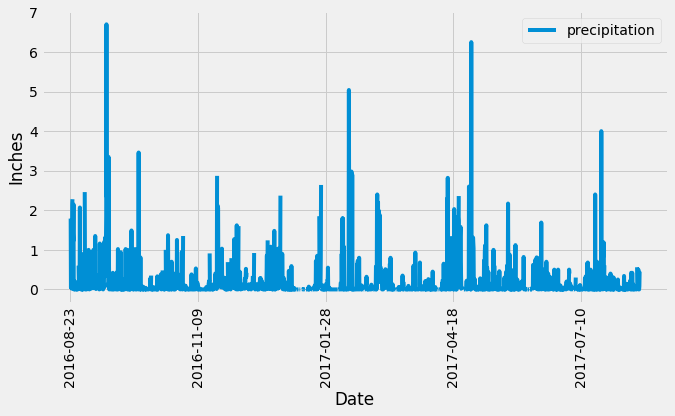

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
LatestDate = (session.query(Measurement.date).order_by(Measurement.date.desc()).first())
# print(LatestDate) 
# Calculate the date 1 year ago from the last data point in the database
PrevYear   = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
Results    = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= PrevYear).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
Df = pd.DataFrame(Results, columns=['date', 'precipitation'])
Df.set_index(Df['date'], inplace=True)
# Sort the dataframe by date
Df = Df.sort_index()
# Use Pandas Plotting with Matplotlib to plot the data
Df.plot   (figsize = (10,5))
plt.xticks(rotation = 90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()

In [26]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [27]:
# Design a query to show how many stations are available in this dataset?
stationsCount = session.query(Station).count()
print(f"Station Count: {stationsCount}")

Station Count: 9


In [28]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [29]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

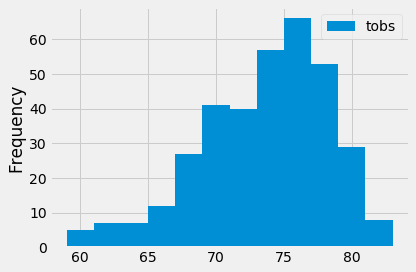

In [30]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Results = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= PrevYear).all()
# Convert To DataFrame
df = pd.DataFrame(Results, columns=['tobs'])
# Plot in 12 bins
df.plot.hist(bins=12)
plt.tight_layout()

## Bonus Challenge Assignment

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [40]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
TripTemp = calc_temps('2016-08-02','2016-08-09')
TripTemp

[(72.0, 78.34615384615384, 83.0)]

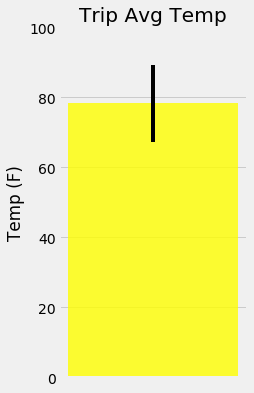

In [45]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
MinTemperature = TripTemp[0][0]
AvgTemperature = TripTemp[0][1]
MaxTemperature = TripTemp[0][2]

MinError = AvgTemperature - MinTemperature
MaxError = MaxTemperature - AvgTemperature

plt.figure(figsize=(3,6))
plt.bar(0, AvgTemperature, yerr=[MaxTemperature - MinTemperature], color = 'yellow', alpha=.8)
plt.title('Trip Avg Temp')
plt.ylim(0,100)
plt.ylabel('Temp (F)')
plt.xticks([])
plt.show()

[(62.0, 69.15384615384616, 77.0)]